# ELECTRA Multi-lingual Model

### This notebook contains the implementation of the ELECTRA model pre-trained on the multi-lingual language set coming from `Datasets/ELECTRA/train_en.csv`

### The following steps are taken to establish the model
- **Data exploration and visualization**
- **Model definition**
- **Optimizer algorithm selection**
- **Loss function selection**
- **Training loop**
- **Model saving**

In [1]:
!pip install -q keras-nlp --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.1/644.1 kB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 108.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 112.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.


In [2]:
import matplotlib.pyplot as plt
import pandas
import numpy
import keras_nlp
import keras
import tensorflow
import os

keras.mixed_precision.set_global_policy("mixed_float16")

#### Data Exploration and Visualization

In [4]:
#electra_multi_dataset = pandas.read_csv("Datasets/ELECTRA/train_all_languages.csv")
electra_multi_dataset = pandas.read_csv("train_all_languages.csv")
electra_multi_dataset.head()

,Unnamed: 0,id,premise,hypothesis,lang_abv,language,label,label_name
0,0,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2,contradiction
1,1,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0,entailment
2,2,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1,neutral
3,3,ed7d6a1e62,"Bir çiftlikte birisinin, ağıla kapatılmış bu ö...",Çiftlikte insanlar farklı terimler kullanırlar.,tr,Turkish,0,entailment
4,4,5a0f4908a0,ریاست ہائے متحدہ امریکہ واپس آنے پر، ہج ایف بی...,ہیگ کی تفتیش ایف بی آئی اہلکاروں کی طرف سے کی...,ur,Urdu,0,entailment


##### Validation to ensure the data is clean when being passed to the model

In [ ]:
electra_multi_dataset.isna().sum()

Unnamed: 0    0
id            0
premise       0
hypothesis    0
lang_abv      0
language      0
label         0
label_name    0
dtype: int64

In [ ]:
electra_multi_dataset.label[~electra_multi_dataset.label.isin([0, 1, 2])].any()

False

##### Descriptions and summaries of data

In [ ]:
electra_multi_dataset.id.count()

6060

- A fairly small dataset relatively speaking to other sources.

In [ ]:
electra_multi_dataset.hypothesis.describe()

count                                                  6060
unique                                                 6060
top       Practice groups are not permitted to work on t...
freq                                                      1
Name: hypothesis, dtype: object

In [ ]:
for i in range(10):
    print(electra_multi_dataset.hypothesis[i])

Practice groups are not permitted to work on these issues.
J'essayais d'accomplir quelque chose.
เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร
Çiftlikte insanlar farklı terimler kullanırlar.
ہیگ کی تفتیش ایف بی آئی اہلکاروں  کی طرف سے کی گئی
From St. Ann's Bay to Cockpit Country.
Краска изменяется в соответствии с цветом.
Könnte das Interesse mehr als 20 sein?
大人刚刚接受了我的意见，并且采取了相应的行动。
Watoto wangeweza kwenda kwa majirani zao nyumba.


- All hypothesis are unique and follow the structure shown above. The premises that follow may either directly follow from the hypothesis, contradict it or not contain enough information to make a proper conclusion.

In [ ]:
electra_multi_dataset.premise.describe()

count                                                  6060
unique                                                 4943
top       Court officials include the phone numbers of t...
freq                                                      3
Name: premise, dtype: object

In [ ]:
for i in range(10):
    print(electra_multi_dataset.premise[i])

These are issues that we wrestle with in practice groups of law firms, she said. 
Des petites choses comme celles-là font une différence énorme dans ce que j'essaye de faire.
ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสดงออกและได้เล่นหลายบทบาทไปพร้อมกัน ๆ อาจช่วยให้เด็กจับความคล้ายคลึงและความแตกต่างระหว่างผู้คนในด้านความปรารถนา ความเชื่อ และความรู้สึกได้
Bir çiftlikte birisinin, ağıla kapatılmış bu öküzleri kesmeliyiz dediğini duyabilirsiniz bu muhtemelen şu anlama gelir, yüklenecek olanları ayırın.
ریاست ہائے متحدہ امریکہ واپس آنے پر، ہج ایف بی آئی کے ایجنٹوں کے ذریعے ہوائی اڈے پر ملاقات کی، تحقیقات کی، اور اگلے دن وفاقی گرین جوری سے پہلے اسامہ بن لادن کی تحقیقات سے ملاقات کی.
From Cockpit Country to St. Ann's Bay
Через каждые сто градусов пятна краски меняют свой цвет, она может быть красной и изменить цвет на синий.
Es fallen zwanzig Prozent Zinsen an
我希望你的领主能够最终开始认识到，向这样的人授予国王委员会的愚蠢行为反对我的所有建议。
Watoto wangegonga milango ya majirani zao na


- **Note:** Not all the premises that follow **are necessarily unique.** This is done to have the model be able to **recognize several conclusions that may be drawn from a hypothesis.**

In [ ]:
electra_multi_dataset.label.describe()

count    6060.000000
mean        0.996865
std         0.827500
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max         2.000000
Name: label, dtype: float64

- From the five-number summary, it can be surmised that most of the data seems to contain neutral conclusions in the premises. This likely suggests that the model will need to learn and encode finer details in the premises to draw accurate conclusions and predictions.

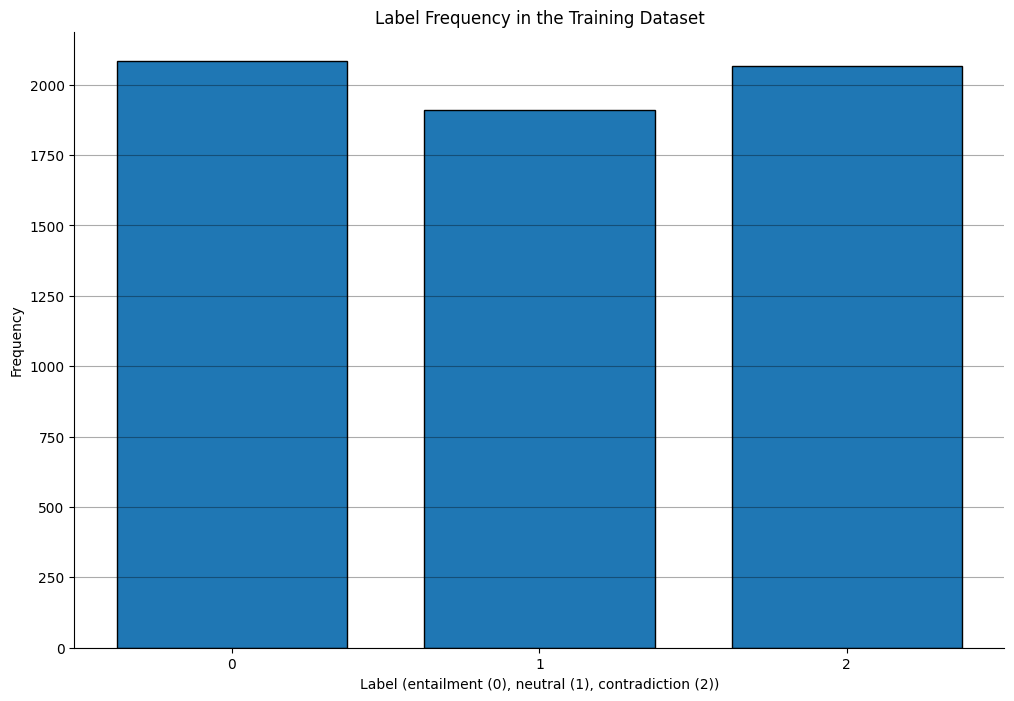

In [ ]:
labels = electra_multi_dataset.label.to_numpy()

plt.figure(figsize=(12, 8))

plt.hist(labels, bins=range(4), align="left", rwidth=0.75, edgecolor="black")

plt.xticks(numpy.arange(3))

for pos in ["top", "right"]:
    plt.gca().spines[pos].set_visible(False)

plt.grid(axis="y", alpha=0.33, color="black")

plt.xlabel("Label (entailment (0), neutral (1), contradiction (2))")

plt.ylabel("Frequency")

plt.title("Label Frequency in the Training Dataset")

plt.show()

- From the historgram above, it seams that the most frequent premise is an entailment, while a neutral conclusion happens the least.

In [ ]:
def get_length_of_text(_text):
    return len(_text)


length_of_hypothesis_texts = electra_multi_dataset.hypothesis.apply(get_length_of_text)

length_of_premise_texts = electra_multi_dataset.premise.apply(get_length_of_text)

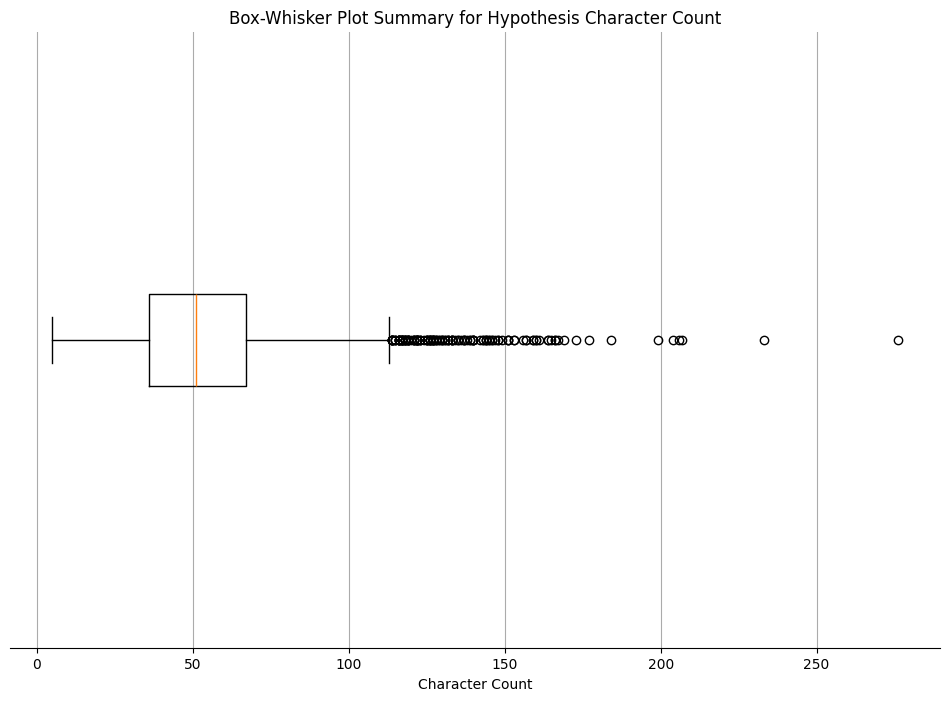

In [ ]:
plt.figure(figsize=(12, 8))

plt.boxplot(length_of_hypothesis_texts, vert=False)

for pos in ["top", "right", "left"]:
    plt.gca().spines[pos].set_visible(False)

plt.gca().get_yaxis().set_visible(False)

plt.grid(axis="x", alpha=0.33, color="black")

plt.xlabel("Character Count")

plt.title("Box-Whisker Plot Summary for Hypothesis Character Count")

plt.show()

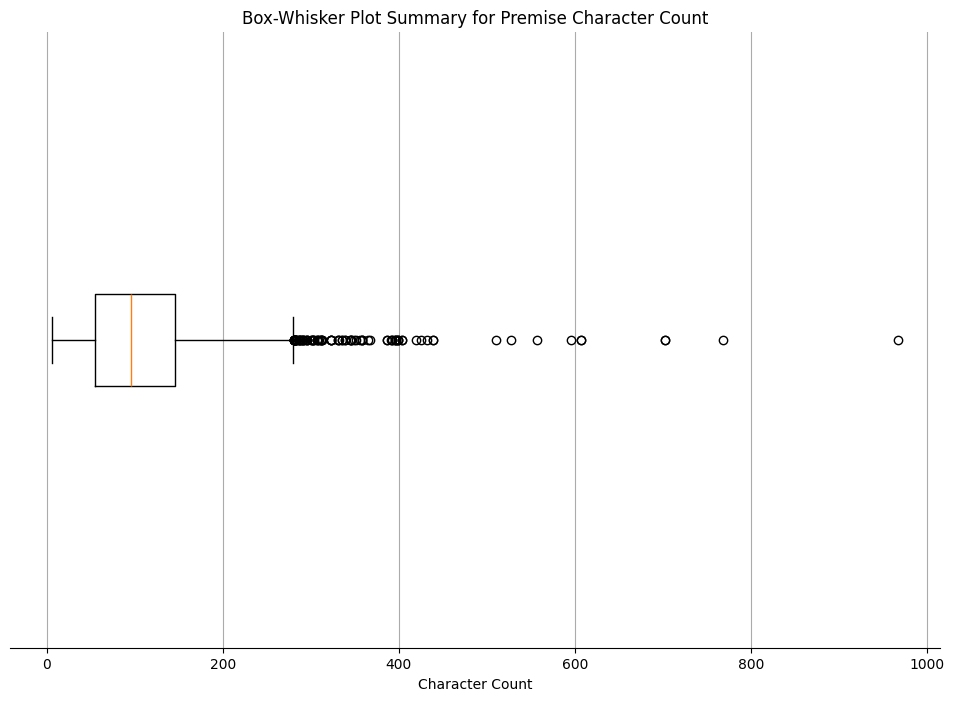

In [ ]:
plt.figure(figsize=(12, 8))

plt.boxplot(length_of_premise_texts, vert=False)

for pos in ["top", "right", "left"]:
    plt.gca().spines[pos].set_visible(False)

plt.gca().get_yaxis().set_visible(False)

plt.grid(axis="x", alpha=0.33, color="black")

plt.xlabel("Character Count")

plt.title("Box-Whisker Plot Summary for Premise Character Count")

plt.show()

- From the summary plots of the character counts in the texts, it can be seen that there appear to be many outliers in the distribution. This means that there exists several text elements that are much longer than upper limits of the distribution. This may affect the encoding of the textual embeddings in the model.

- Otherwise, it would seem on average that the premises are longer than the hypotheses.

#### Model Definition

In [5]:
def split_labels(x, y):
    return (x[0], x[1]), y


def get_max_token_length(dataset, preprocessor):
  token_lengths = []

  for hypothesis, premise in dataset[["hypothesis", "premise"]].values:

    encoded = preprocessor([hypothesis, premise])
    encoded_np = encoded["padding_mask" ]. numpy()
    non_padding_count = encoded_np.sum()
    token_lengths.append(non_padding_count)

  return max(token_lengths)


def plot_model_result(_losses, _accuracies, batch_size, _is_training=True):
    plt.style.use('seaborn-v0_8-dark')

    fig, (momentum_loss_ax, momentum_acc_ax) = plt.subplots(1, 2, figsize=(16,6))
    momentum_loss_ax.plot(numpy.arange(1, len(_losses) + 1), _losses)
    momentum_loss_ax.set_xlabel(f"Epoch (Batch size = {batch_size})")
    momentum_loss_ax.set_xticks(numpy.arange(1, len(_losses) + 1))
    momentum_loss_ax.set_ylabel("CCE loss")
    momentum_loss_ax.set_title(f"{'Training' if _is_training else 'Validation'} Epoch vs. Loss for ELECTRA Multi")
    momentum_loss_ax.grid()

    momentum_acc_ax.plot(numpy.arange(1, len(_accuracies) + 1), _accuracies)
    momentum_acc_ax.set_xlabel(f"Epoch (Batch size = {batch_size})")
    momentum_acc_ax.set_xticks(numpy.arange(1, len(_accuracies) + 1))
    momentum_acc_ax.set_ylabel("Accuracy (%)")
    momentum_acc_ax.set_yticks(numpy.arange(0, 1.1, .1))
    momentum_acc_ax.set_title(f"{'Training' if _is_training else 'Validation'} Epoch vs. Accuracy for ELECTRA Multi")
    momentum_acc_ax.grid()

    plt.show()

In [6]:
VALIDATION_SPLIT = 0.2
TRAIN_SIZE = int(electra_multi_dataset.shape[0] * (1-VALIDATION_SPLIT))

training_dataset = (
    tensorflow.data.Dataset.from_tensor_slices(
        (
            electra_multi_dataset[["hypothesis", "premise"]].values,
            electra_multi_dataset["label"].values
        )
    )
)

train_dataset = training_dataset.take(TRAIN_SIZE)
val_dataset = training_dataset.skip(TRAIN_SIZE)

batch_size = 32

num_epochs = 5

train_preprocessed = train_dataset.map(split_labels, tensorflow.data.AUTOTUNE).cache().shuffle(buffer_size=batch_size, seed=42).batch(batch_size, drop_remainder=True).prefetch(tensorflow.data.AUTOTUNE)
val_preprocessed = val_dataset.map(split_labels, tensorflow.data.AUTOTUNE).cache().shuffle(buffer_size=batch_size, seed=42).batch(batch_size, drop_remainder=True).prefetch(tensorflow.data.AUTOTUNE)

100%|██████████| 418M/418M [00:27<00:00, 16.0MB/s]


Epoch 1/5
151/151 ━━━━━━━━━━━━━━━━━━━━ 130s 313ms/step - loss: 1.1084 - sparse_categorical_accuracy: 0.3391 - val_loss: 1.1073 - val_sparse_categorical_accuracy: 0.3345
Epoch 2/5
151/151 ━━━━━━━━━━━━━━━━━━━━ 37s 245ms/step - loss: 1.1035 - sparse_categorical_accuracy: 0.3496 - val_loss: 1.0980 - val_sparse_categorical_accuracy: 0.3514
Epoch 3/5
151/151 ━━━━━━━━━━━━━━━━━━━━ 37s 245ms/step - loss: 1.1015 - sparse_categorical_accuracy: 0.3406 - val_loss: 1.0979 - val_sparse_categorical_accuracy: 0.3514
Epoch 4/5
151/151 ━━━━━━━━━━━━━━━━━━━━ 37s 244ms/step - loss: 1.1009 - sparse_categorical_accuracy: 0.3418 - val_loss: 1.0981 - val_sparse_categorical_accuracy: 0.3514
Epoch 5/5
151/151 ━━━━━━━━━━━━━━━━━━━━ 37s 244ms/step - loss: 1.0998 - sparse_categorical_accuracy: 0.3391 - val_loss: 1.0980 - val_sparse_categorical_accuracy: 0.3514


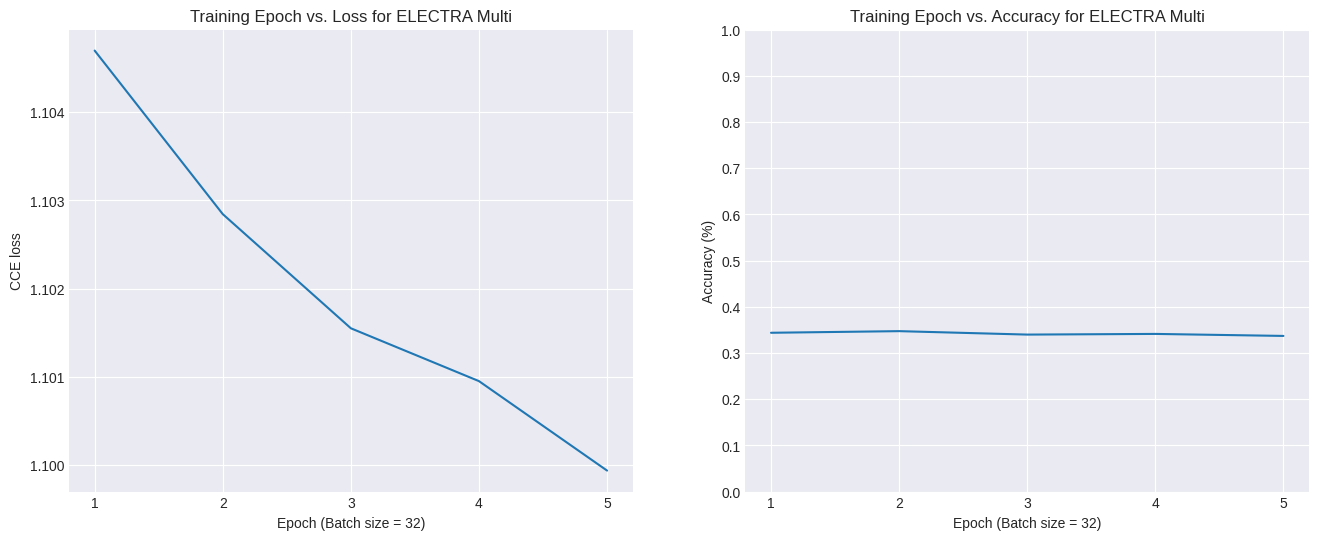

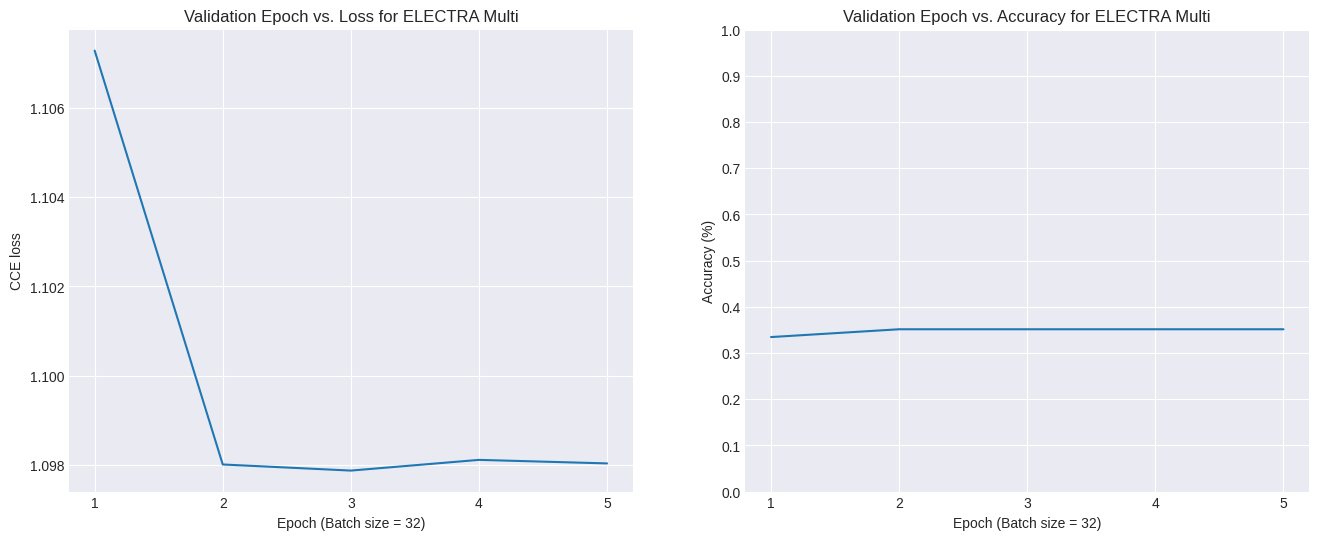

In [13]:
electra_discriminator_token = keras_nlp.models.Tokenizer.from_preset("electra_base_discriminator_uncased_en")

bert_preprocessor = keras_nlp.models.BertTextClassifierPreprocessor(electra_discriminator_token, sequence_length=240)

train_set = (
    train_preprocessed.map(bert_preprocessor, tensorflow.data.AUTOTUNE).cache().prefetch(tensorflow.data.AUTOTUNE)
)

val_set = (
    val_preprocessed.map(bert_preprocessor, tensorflow.data.AUTOTUNE).cache().prefetch(tensorflow.data.AUTOTUNE)
)

electra_discriminator_back = keras_nlp.models.Backbone.from_preset("electra_base_discriminator_uncased_en")

bert_classifier = keras_nlp.models.BertClassifier(electra_discriminator_back, 3, preprocessor=None)

classifier_history = bert_classifier.fit(train_set, epochs=5, validation_data=val_set)
training_losses = classifier_history.history["loss"]

training_accuracies = classifier_history.history["sparse_categorical_accuracy"]

validation_losses = classifier_history.history["val_loss"]

validation_accuracies = classifier_history.history["val_sparse_categorical_accuracy"]

plot_model_result(training_losses, training_accuracies, batch_size)

plot_model_result(validation_losses, validation_accuracies, batch_size, False)

#### Optimizer and Loss selection will remain set to the defaults of the preset

#### Saving the Model

In [ ]:
# Note that only the classifier requires the weights to be saved.
# No training is being done on the tokenizer or preprocessor since we are interested in pretraining the classifier.
dir_path = "Models/ELECTRA"
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

bert_classifier.save_weights("Models/ELECTRA/ELECTRA_EN.weights.h5")